## Algoritmo de clasificación Multiclase
En este jupyter se dan los código básicos para implementar este algoritmo en una aplicación.

In [1]:
#Dependencias. Librerías usadas para la demostración del algoritmo

import matplotlib.pyplot as plt
import numpy as np
import random
import scipy
from scipy import stats
from collections import Counter

In [2]:
#Inicialización de variables. Aquí están todas las variables que se pueden inicializar
num_usuarios = 15
beta = 0.05
n = beta/num_usuarios**2
#props = [0.1, 0.1, 0.05, 0.05, 0.2, 0.1, 0.1, 0.1, 0.05, 0.15]
props = [0.3, 0.2, 0.3, 0.1, 0.1]
num_clases = len(props)
alpha = 0.997
numero_de_datos = 10000




# Creación del input:
En las siguientes celdas, crearemos el input correspondiente para el algoritmo, que es:

+ Un set de usuarios con una estimación de precisión y número de datos para dicha precisión

+ Un dataset correspondiente



La siguiente función crea una lista con usuarios, donde cada usuario tiene una matriz donde se registran las precisiones y los números de datos que han sido usados para estimarlas


$p_{ij}$  = probabilidad que el usuario k proponga la clase i condicionado a que la clase real sea j

In [111]:
def generar_usuarios(n, a, m):
    '''Esta función crea una lista de n usuarios.
    input: n,m números naturales, a, b límite inferior y número total de datos por usuario
    output: lista de tuplas con la precisión simulada del usuario (extraida de una distribución pareto)
    y el número de datos etiquetados con los que se ha estimado esta precisión (escogidos uniformemente entre 30 y m+30)'''
    usuarios = []
    ress = []
    matrs = []
    for i in range(n):
        ress = 1-np.random.pareto(15+random.randint(0, i), num_clases)
        for i in range(len(ress)):
            if ress[i] < 0:
                ress[i] = -ress[i]
        matr = np.asarray(ress)*(np.eye(num_clases))
        valores = np.zeros(matr.shape)
        for i in range(matr.shape[0]):
            for j in range(matr.shape[1]):
                if i != j :
                    valores[i, j] = (random.random())
        valores = np.eye(num_clases)*np.sum(valores, axis = 0) + valores
        valores = valores/np.diag(valores)
        valores = valores - np.eye(num_clases)
        matr = matr + valores*(np.diag(np.eye(num_clases)-matr).reshape(num_clases, 1))
        matr = matr.T
        matr = matr/np.sum(matr, axis = 0)
        matrs.append(matr)
        

    for i in range(len(matrs)):
        ns = np.random.randint(a, 1000, num_clases*num_clases).reshape((num_clases, num_clases))
        ns = ns/ns.sum()
        ns = np.floor(ns*m)
        

        usuarios.append((matrs[i], ns))
    return usuarios

In [112]:
lista = generar_usuarios(num_usuarios, 30, 1000)

Precisiones de los usuarios visualizados como distribuciones

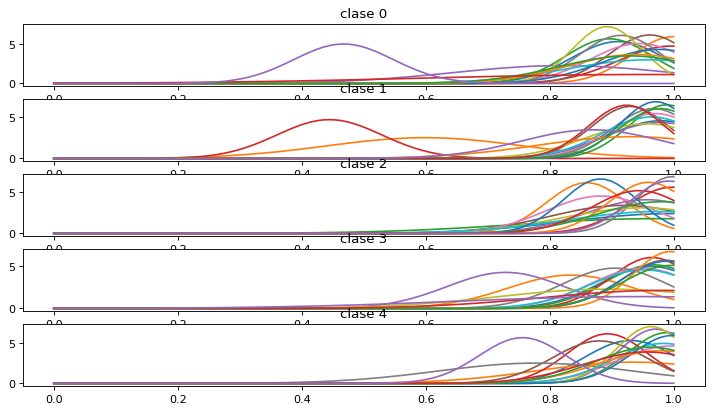

In [113]:
def gaus(media, n, x):
    #Parametro de varianza
    var = np.sqrt(0.5*(1-0.5)/n)
    return np.exp(-(x-media)**2/(2*var**2))/np.sqrt(2*np.pi*var**2)

def dibujar(usuarios, x):
    plt.figure(figsize=(11, 6), dpi=80)
    for j in range(num_clases):
        plt.subplot(num_clases,1,j+1)
        plt.title('clase '+str(j))
        for i in range(len(usuarios)):
            plt.plot(x, gaus(np.diag(usuarios[i][0])[j], np.diag(usuarios[i][1])[j],x))
    plt.show()
    
x = np.linspace(0, 1, 100)
dibujar(lista, x)

### Creación del dataset

En esta función, creamos el dataset. Este consistirá en un array donde cada elemento es la clase correspondiente a cada dato, respetando las proporciones propuestas al principio

In [ ]:
def generar_dataset(m, props):
    data = []
    us = np.cumsum(props)
    for i in range(m):
        ind = list((np.cumsum(np.asarray(props)) < random.random())).index(False)
        data.append(ind)
    return data

In [ ]:
data = generar_dataset(numero_de_datos, props)

In [ ]:
data = generar_dataset(numero_de_datos, props)
for (i, n) in Counter(data).items():
    print('for '+str(i)+' we get ' + str(n/numero_de_datos)+' that was '+str(props[i]))

## Simulación del proceso de etiquetado
Obviamente, el etiquetador va a fallar en algún momento. Por lo tanto, nos serviremos que la siguiente función, que realizará un guess del usuario acorde a la distribución dada por sus precisión con respecto a una clase y el número de datos que apoya este parámetro

In [ ]:

def generar_guess(usuario, usuarios, dato):

    t = np.ones((num_clases, 1))
    Proy = np.eye(num_clases)- t.dot(t.T)/(t.T.dot(t))
    mu = (Proy.dot(lista[usuario][0][:,data[dato]]) + np.ones(num_clases)/num_clases).reshape(num_clases, 1)

    Sigma = ((np.eye(num_clases)*mu-mu.dot(mu.T))/(np.sum(lista[usuario][1][:,data[dato]])))
    mat = gen_mat_bas(num_clases)
    
    Sigma_subesp = mat.T.dot(Sigma).dot(mat)
    mu_subesp = mat.T.dot(mu-np.ones((num_clases, 1))/num_clases)

    params = np.random.multivariate_normal(mu_subesp.reshape(num_clases-1, ), Sigma_subesp)

    new_mu = np.linalg.pinv(mat.T).dot(params).reshape(num_clases, 1) + np.ones((num_clases, 1))/num_clases
    while (new_mu < 0).any():
        params = np.random.multivariate_normal(mu_subesp.reshape(num_clases-1, ), Sigma_subesp)
        new_mu = np.linalg.pinv(mat.T).dot(params).reshape(num_clases, 1) + np.ones((num_clases, 1))/num_clases
    print(new_mu)
    elements = list(range(num_clases))
    
    return (np.random.choice(elements, 1, p = list(new_mu.reshape(num_clases)))[0], new_mu)


# Procesamiento
En esta parte, usaremos el input y con diversas funciones lo convertiremos en un set de etiquetas útiles, superando la aleatoriedad de los usuarios. Para empezar, subestimaremos los parámetros de los usuarios, de forma que el parámetro verdadero del usuario siempre se encuentre con probabilidad $1-\beta$ mejor de la subestimación. Para enteder esto también introducimos una regla de orden (arbitraria). Dos vectores en el espacio tienen esta relación $x < y$ sii $\|Mx\| < \|My\|$, donde M es la proyección de un vector sobre el espacio generado por $(1, -1, -1, ..., -1)$, dependiendo de a qué clase nos estemos refiriendo. Llamemos a este vector $C_k$, donde la k es donde está el 1 (en el ejemplo anterior, el generador era $C_1$. Por tanto, consideramos que un vector en el espacio de distribución es "mejor" que otro si su proyección sobre este espacio es mayor. Es decir, la proporción de precisión vs error es más rentable.

###### Posible mejora: 
Este vector es arbitrario. Igual sería posible encontrar uno que, usando las proporciones de las clases, obtenga mejores resultados (es mejor ser un poco mejor en una clase pequeña que un poco mejor en una clase grande en casi cualquier caso, sin perder precisión en las otras clases)

In [118]:
def lista_subestimada(lista, prob_sub):

    nueva_lista = []
    for i in range(len(lista)):
        nueva_lista.append(np.asarray(list(lista[i][0])))
        for j in range(num_clases):
                nueva_lista[i][j, j] = (lista[i][0][j, j] + (np.sqrt(lista[i][0][j, j]*(1-lista[i][0][j, j])/np.sum(lista[i][1], axis = 0)[j]))*stats.norm.ppf(prob_sub))
                r = 1 - nueva_lista[i][j, j]
                z = np.sum(nueva_lista[i][:,j]) - nueva_lista[i][j, j]
                temp = np.ones(num_clases)*r/z
                temp[j] = 1
                nueva_lista[i][:,j] = nueva_lista[i][:,j]*temp

    return nueva_lista

In [119]:
listasub = lista_subestimada(lista, beta)

### Base para el espacio $<C_k> ^\perp$
Una base como cualquier otra (que además sea ortogonal) que he encontrado para el espacio en cuestión es la siguiente: $\{(1, -1, 0, ..., 0), \\ (1, 1, -2, 0, ..., 0), \\ (1, 1, 1, -3, 0, ..., 0), ...\}$
Esto en una matriz queda de la siguiente forma:

In [124]:

def gen_mat_bas(n):
    temp = np.zeros((n, n-1))
    for i in range(n):
        for j in range(n-1):
            if j >= i:
                temp[i, j] = 1
            elif i == j+1 :
                temp[i, j] = -(j+1)
    return temp



In [126]:
gen_mat_bas(5)

array([[ 1.,  1.,  1.,  1.],
       [-1.,  1.,  1.,  1.],
       [ 0., -2.,  1.,  1.],
       [ 0.,  0., -3.,  1.],
       [ 0.,  0.,  0., -4.]])

Necesitamos esta función para realizar cálculos con generar_guess

In [127]:
generar_guess(0, lista, 0)

(0,
 array([[0.9152004 ],
        [0.03726423],
        [0.01414371],
        [0.00529195],
        [0.02809972]]))

In [128]:
data[0]

0

### Formula de bayes
Usando la formula de bayes, estimamos la probabilidad de que la etiqueta esté correctamente etiquetada basándonos en las probabilidades a posteriori de los usuarios, que se equivoquen o acierten.

In [129]:
def prob_correcta(E, dic_votantes, lista):
    '''Esta función solicita la clase de la etiqueta que se quiere comprobar, E, un diccionario que contiene los votantes de
    cada clase, y la lista de usuarios.'''
    probs = list(props)
    for k in range(num_clases):
        for i, vot in dic_votantes.items():

            if len(vot) >= 1:
                for le in range(len(vot)):
                    if i == k:
                        probs[k] = probs[k]*lista[vot[le]][k, k]
                    elif i!= k:
                        probs[k] = probs[k]*(lista[vot[le]][i, k])
    probs = probs/np.sum(probs)
    

    return probs[E]

Y finalmente, la etiquetación correspondiente, de parte de todos los usuarios. Como siempre, ya que no hemos implementado algoritmo de recomendación, la selección de usuarios es aleatoria.

In [132]:
def etiquetar(usuarios, usuariossub, data, alpha):
    coleccion = []
    new_col = []
    for i in range(len(data)):
        
        coleccion.append({k: [] for k in range(num_clases)})

        z = 1
        p = 0
        if (int(i/len(data)) > 0.5):
            print('mitad de los datos')
            z = 0
        while p == 0:
            
            etiquetador = random.sample(range(len(usuarios)), 1)
            etiqueta, mumu = generar_guess(etiquetador[0], usuarios, i)

            coleccion[i][etiqueta].append(etiquetador[0])
            for l in range(num_clases):
                if (prob_correcta(l, coleccion[i], usuariossub) > alpha):
                    new_col.append(l)
                    p = 1

            
    return coleccion, new_col

In [133]:
col, new_col = etiquetar(lista, listasub, data, 0.9)

Veamos cuál es la probabilidad de que el primer dato tenga etiqueta perteneciente a la clase 0:

Cuál es la probabilidad de que el dato número 0 esté correctamente etiquetado?

In [135]:
prob_correcta(data[0], col[0], listasub)

0.976005147702574

### Validación del algoritmo
Veamos que tan bueno ha sido el algoritmo en la simulación:


In [136]:
def get_precs(c):
    precs = np.zeros(num_clases)
    for n in range(num_clases):
        precs[n] = c[n, n]/np.sum(c, axis = 0)[n]
    return precs

def get_conf_final(coleccion, data):
    tabla = np.zeros((num_clases, num_clases))
    for i in range(len(data)):
        tabla[coleccion[i], data[i]] = tabla[coleccion[i], data[i]]+1
    
    return tabla

In [139]:
get_precs(get_conf_final(new_col, data))

array([0.97497497, 0.97207511, 0.98155738, 0.96072508, 0.95522388])

Y como podemos observar, obtenemos resultados muy buenos. Ahora es necesario probar qué sucede cuando nuestra población es algo peor, o mediocre ¿Necesitaremos demasiados usuarios por etiqueta? Estoy trabajando en otro algoritmo que no use la subestimación de usuarios para tener un control más preciso sobre la indeterminación de cada usuario.